# **FAKE NEWS CLASSIFICATION**
Final Project Bootcamp - Kelompok 2 Data Alchemist

# IMPORT LIBRARY

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [1]:
# Basic Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Library pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [41]:
# Library modeling
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [36]:
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# INPUT DATA

In [6]:
file_path = '/content/drive/MyDrive/Final-Project-Fake-News-Classification/news.csv'
df = pd.read_csv(file_path)
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


# EXPLORATORY DATA ANALYSIS (EDA)

In [7]:
df.shape

(6335, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [9]:
# cek missing value
df.isnull().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


diketahui bahwa tidak ada missing value dalam dataset

In [10]:
# cek duplikasi data
df.duplicated().sum()

np.int64(0)

diketahui bahwa tidak ada data yang terduplikasi dalam dataset


Label Distribution:
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


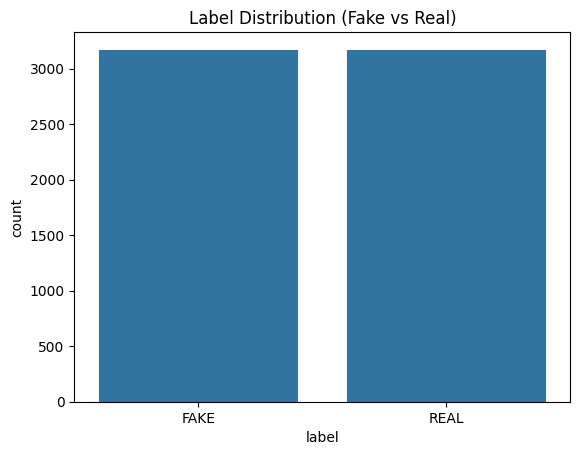

In [11]:
print("\nLabel Distribution:")
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title('Label Distribution (Fake vs Real)')
plt.show()

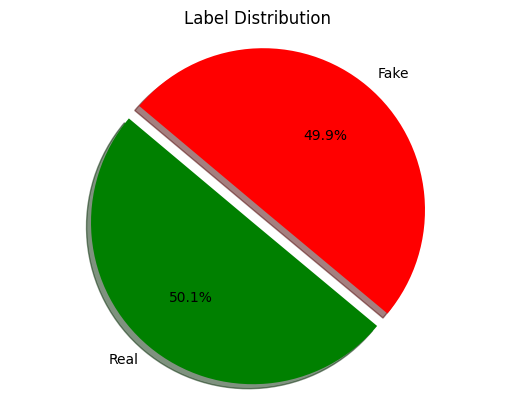

In [12]:
# distribusi dalam pie chart
labels = df['label'].value_counts()
colors = ['green', 'red']
explode = (0.1, 0)
plt.pie(labels, labels=['Real', 'Fake'], colors=colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Label Distribution')
plt.show()


Statistics of Title Length:
count    6335.000000
mean       65.277664
std        23.733657
min         1.000000
25%        49.000000
50%        64.000000
75%        78.000000
max       289.000000
Name: title_length, dtype: float64


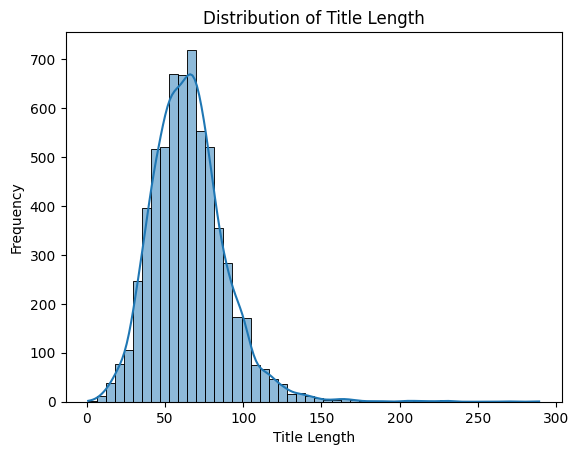

In [13]:
# cek panjang teks pada fitur "title"

df['title_length'] = df['title'].apply(lambda x: len(str(x)))
print("\nStatistics of Title Length:")
print(df['title_length'].describe())
sns.histplot(df['title_length'], bins=50, kde=True)
plt.title('Distribution of Title Length')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.show()

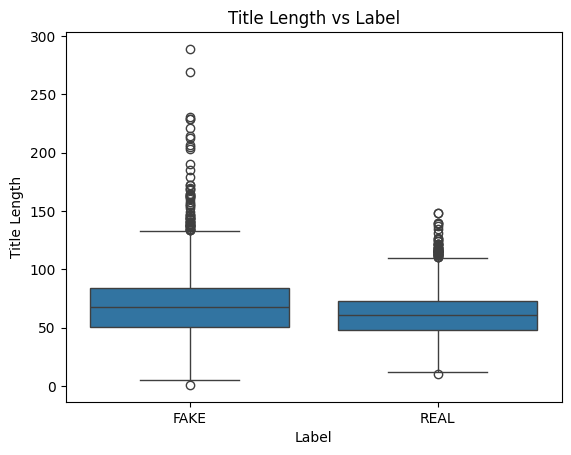

In [14]:

sns.boxplot(x='label', y='title_length', data=df)
plt.title('Title Length vs Label')
plt.xlabel('Label')
plt.ylabel('Title Length')
plt.show()


Statistics of Text Length:
count      6335.000000
mean       4707.250355
std        5090.956446
min           1.000000
25%        1741.500000
50%        3642.000000
75%        6192.000000
max      115372.000000
Name: text_length, dtype: float64


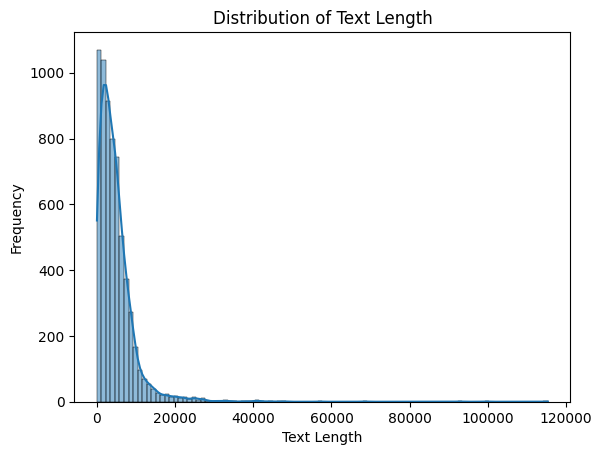

In [15]:
# Menganalisis panjang teks pada fitur 'text'
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
print("\nStatistics of Text Length:")
print(df['text_length'].describe())
sns.histplot(df['text_length'], bins=100, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

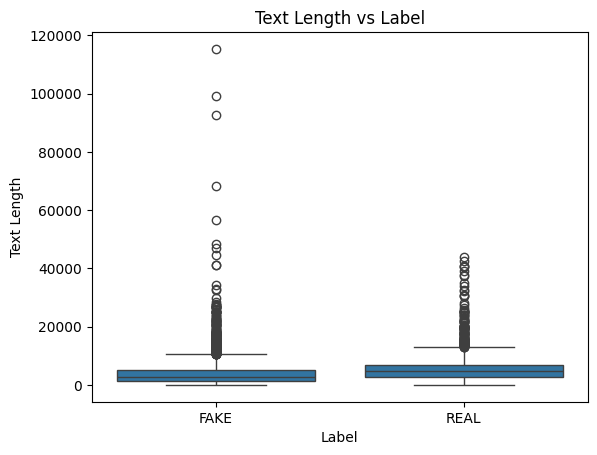

In [16]:
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length vs Label')
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.show()

# PRE-PROCESSING DATA

In [17]:
# menghapus kolom yang tidak dibutuhkan
df = df.drop(columns=["Unnamed: 0"], axis=1)
print("Kolom 'Unnamed: 0' berhasil dihapus.")

Kolom 'Unnamed: 0' berhasil dihapus.


In [18]:
df.head()

,title,text,label,title_length,text_length
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840


In [21]:
# Inisialisasi lemmatizer dan set stopwords bahasa Inggris
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) # Menghapus karakter non-alfanumerik dan tanda baca
        text = text.lower()  # Mengubah teks menjadi huruf kecil
        words = text.split()  # Tokenisasi (memisahkan teks menjadi kata-kata)
        words = [word for word in words if word not in stop_words]  # 4. Menghapus stopwords
        words = [lemmatizer.lemmatize(word) for word in words]  # 5. Lemmatisasi (mengubah kata ke bentuk dasarnya)
        return ' '.join(words) # Menggabungkan kembali kata-kata menjadi teks
    return ''

In [26]:
# Terapkan preprocessing ke kolom 'title' dan 'text'
df['title_processed'] = df['title'].apply(preprocess_text)
df['text_processed'] = df['text'].apply(preprocess_text)

In [27]:
# Menampilkan beberapa hasil preprocessing
print("Contoh teks asli:")
print(df[['title', 'text']].head())
print("\nContoh teks yang telah diproses:")
print(df[['title_processed', 'text_processed']].head())

Contoh teks asli:
                                               title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text  
0  Daniel Greenfield, a Shillman Journalism Fello...  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  
2  U.S. Secretary of State John F. Kerry said Mon...  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  
4  It's primary day in New York and front-runners...  

Contoh teks yang telah diproses:
                                     title_processed  \
0                                 smell hillary fear   
1  watch exact moment paul ryan committed politic...   
2                    kerry go paris gesture sympathy   
3  bernie supporter twitter erupt anger dnc tried...   
4

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            6335 non-null   object
 1   text             6335 non-null   object
 2   label            6335 non-null   object
 3   title_length     6335 non-null   int64 
 4   text_length      6335 non-null   int64 
 5   title_processed  6335 non-null   object
 6   text_processed   6335 non-null   object
dtypes: int64(2), object(5)
memory usage: 346.6+ KB


In [29]:
df.head(1)

,title,text,label,title_length,text_length,title_processed,text_processed
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,smell hillary fear,daniel greenfield shillman journalism fellow f...


# FEATURE ENGINEERING

In [30]:
# Inisialisasi TF-IDF Vectorizer untuk judul
tfidf_title = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_title.fit(df['title_processed'])
X_title = tfidf_title.transform(df['title_processed']).toarray()

In [31]:
# Inisialisasi TF-IDF Vectorizer untuk teks
tfidf_text = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
tfidf_text.fit(df['text_processed'])
X_text = tfidf_text.transform(df['text_processed']).toarray()

In [32]:
# Menggabungkan fitur dari judul dan teks
X = np.concatenate((X_title, X_text), axis=1)
y = df['label'].apply(lambda x: 1 if x == 'FAKE' else 0) # Mengubah label menjadi numerik (1 untuk 'FAKE', 0 untuk 'REAL')

In [33]:
# membagi data set menjadi data training dan data testing dengan 80 /20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Menampilkan bentuk dari fitur yang dihasilkan dan data yang dibagi
print("Bentuk fitur TF-IDF untuk judul:", X_title.shape)
print("Bentuk fitur TF-IDF untuk teks:", X_text.shape)
print("Bentuk fitur gabungan (X):", X.shape)
print("Bentuk data latih (X_train):", X_train.shape)
print("Bentuk data uji (X_test):", X_test.shape)
print("Bentuk label latih (y_train):", y_train.shape)
print("Bentuk label uji (y_test):", y_test.shape)

Bentuk fitur TF-IDF untuk judul: (6335, 5000)
Bentuk fitur TF-IDF untuk teks: (6335, 10000)
Bentuk fitur gabungan (X): (6335, 15000)
Bentuk data latih (X_train): (5068, 15000)
Bentuk data uji (X_test): (1267, 15000)
Bentuk label latih (y_train): (5068,)
Bentuk label uji (y_test): (1267,)


In [37]:
# Simpan TF-IDF Vectorizer untuk judul
tfidf_title_filename = 'tfidf_title.pkl'
with open(tfidf_title_filename, 'wb') as file:
    pickle.dump(tfidf_title, file)
print(f"TF-IDF Vectorizer untuk judul disimpan sebagai '{tfidf_title_filename}'")

TF-IDF Vectorizer untuk judul disimpan sebagai 'tfidf_title.pkl'


In [38]:
# Simpan TF-IDF Vectorizer untuk teks
tfidf_text_filename = 'tfidf_text.pkl'
with open(tfidf_text_filename, 'wb') as file:
    pickle.dump(tfidf_text, file)
print(f"TF-IDF Vectorizer untuk teks disimpan sebagai '{tfidf_text_filename}'")

TF-IDF Vectorizer untuk teks disimpan sebagai 'tfidf_text.pkl'


# MODELING

In [39]:
# Inisialisasi model-model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
pa_model = PassiveAggressiveClassifier(random_state=42, max_iter=100, tol=1e-3, loss='squared_hinge')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:42:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost ---
Accuracy: 0.9250197316495659
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       639
           1       0.92      0.93      0.93       628

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



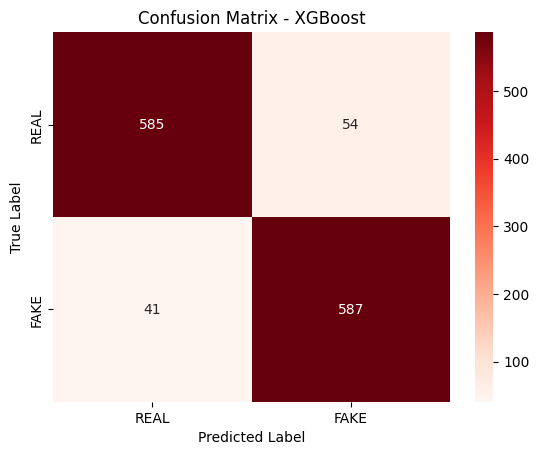

In [42]:
# Latih model XGBoost
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print("\n--- XGBoost ---")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost')
plt.show()


--- Passive-Aggressive Classifier ---
Accuracy: 0.9265982636148382
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       639
           1       0.91      0.94      0.93       628

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



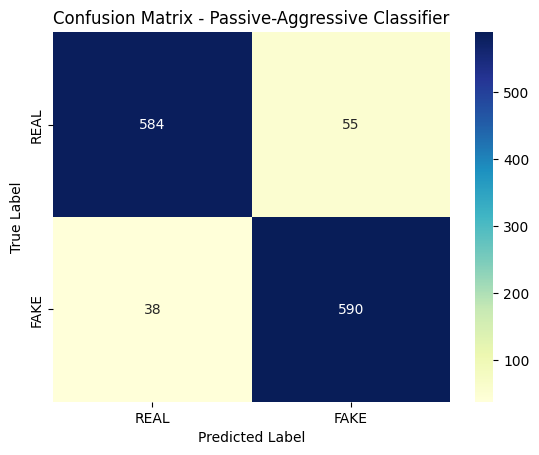

In [43]:
# Latih dan evaluasi model Passive-Aggressive Classifier
pa_model.fit(X_train, y_train)
pa_pred = pa_model.predict(X_test)
print("\n--- Passive-Aggressive Classifier ---")
print("Accuracy:", accuracy_score(y_test, pa_pred))
print("Classification Report:\n", classification_report(y_test, pa_pred))
cm_pa = confusion_matrix(y_test, pa_pred)
sns.heatmap(cm_pa, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Passive-Aggressive Classifier')
plt.show()

# SAVE MODEL

In [44]:
import pickle

In [45]:
# Menyimpan model XGBoost
xgb_model_filename = 'xgboost_model.pkl'
with open(xgb_model_filename, 'wb') as file:
    pickle.dump(xgb_model, file)
print(f"Model XGBoost dengan parameter default berhasil disimpan sebagai '{xgb_model_filename}'")

Model XGBoost dengan parameter default berhasil disimpan sebagai 'xgboost_model.pkl'


In [46]:
# Menyimpan model Passive-Aggressive Classifier
pa_model_filename = 'pac_model.pkl'
with open(pa_model_filename, 'wb') as file:
    pickle.dump(pa_model, file)
print(f"Model Passive-Aggressive Classifier dengan parameter default berhasil disimpan sebagai '{pa_model_filename}'")

Model Passive-Aggressive Classifier dengan parameter default berhasil disimpan sebagai 'pac_model.pkl'
